# SRISHTI'23 - Tutorial 07
## Introduction to Gradient Descent
#### Lab Coordinator: Shantanu Agrawal

In this lab session, we will try to understand about the **Gradient Descent** and some of the properties related to it as well. But before moving further, please look at the [Tutorial 6 notebook](https://colab.research.google.com/drive/113mi94ko2R1iy_st2v7tR1JRMHvXwfLC) to revisit the concepts of Linear Classifiers and Perceptron Learning Algorithms.

Gradient descent is a very important algorithm to understand, as it underpins many of the more advanced algorithms used in Machine Learning and Deep Learning.

A brief overview of the algorithm is

*   start with a random initialization of the solution.
*   incrementally change the solution by moving in the direction of negative gradient of the objective function.
*   repeat the previous step until some convergence criteria is met.

The key equation for change in weight is:
$$w^{k+1} \leftarrow w^k - \eta \Delta J$$
Here, $\eta$ is learning rate and $\Delta J$ is the gradient of the weight as per the loss function.

Let's try to implement the gradient descent algorithm and undersatnd it simultaneoulsy in this lab.

In [1]:
# Importing the required libraries

import numpy as np
import matplotlib.pyplot as plt
import random   

random.seed(42)

We can start by choosing coefficients for a second degree polynomial equation $(a x^2 + bx + c)$ that will distribute the data we will try to model.

Let's define some random x data (inputs) we hope to predict y (outputs) of.

In [3]:
def eval_2nd_degree(coeffs, x):
    """
    Function to return the output of evaluating a second degree polynomial,
    given a specific x value.
    
    Args:
        coeffs: List containing the coefficients a, b, and c for the polynomial.
        x: The input x value to the polynomial.
    
    Returns:
        y: The corresponding output y value for the second degree polynomial.
    
    """

    a = coeffs[0] * (x * x)
    b = coeffs[1] * x
    c = coeffs[2]
    y = a + b + c
    return y

hundred_xs = np.random.uniform(-10, 10, 100)
coeffs = [1, 0, 0]

xs = []
ys = []
for x in hundred_xs:
    y  = eval_2nd_degree(coeffs, x)
    xs.append(x)
    ys.append(y)

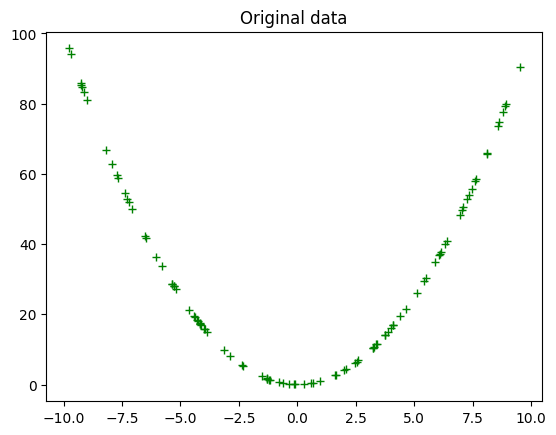

In [4]:
plt.plot(xs, ys, 'g+')
plt.title('Original data')
plt.show()

This is good, but we could improve on this by making things more realistic. You can add noise or **jitter** to the values so they can resemble real-world data.


In [5]:
def eval_2nd_degree_jitter(coeffs, x, j):
    """
    Function to return the noisy output of evaluating a second degree polynomial,
    given a specific x value. Output values can be within [y − j, y + j].
    
    Args:
        coeffs: List containing the coefficients a, b, and c for the polynomial.
        x: The input x value to the polynomial.
        j: Jitter parameter, to introduce noise to output y.
    
    Returns:
        y: The corresponding jittered output y value for the second degree polynomial.
    
    """

    a = coeffs[0] * (x * x)
    b = coeffs[1] * x
    c = coeffs[2]
    y = a + b + c
    
    interval = [y - j, y + j]
    interval_min = interval[0]
    interval_max = interval[1]
    jit_val = random.random() * interval_max      # Generate a random number in range 0 to interval max 
    
    while interval_min > jit_val:                 # While the random jitter value is less than the interval min,
        jit_val = random.random() * interval_max  # it is not in the right range. Re-roll the generator until it 
                                                  # give a number greater than the interval min. 
    
    return jit_val

xs = []
ys = []
for x in hundred_xs:
    y  = eval_2nd_degree_jitter(coeffs, x, 0.1)
    xs.append(x)
    ys.append(y)


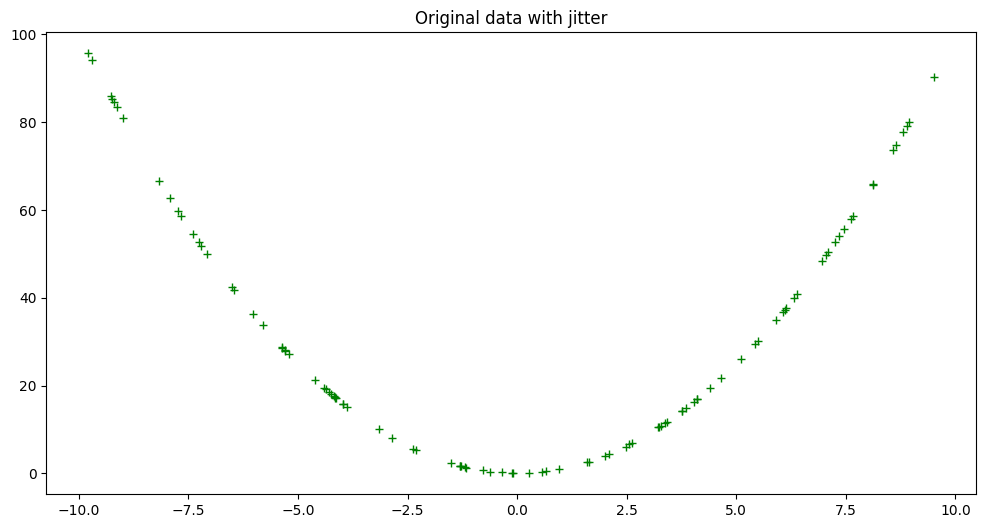

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+')
plt.title('Original data with jitter')
plt.show()

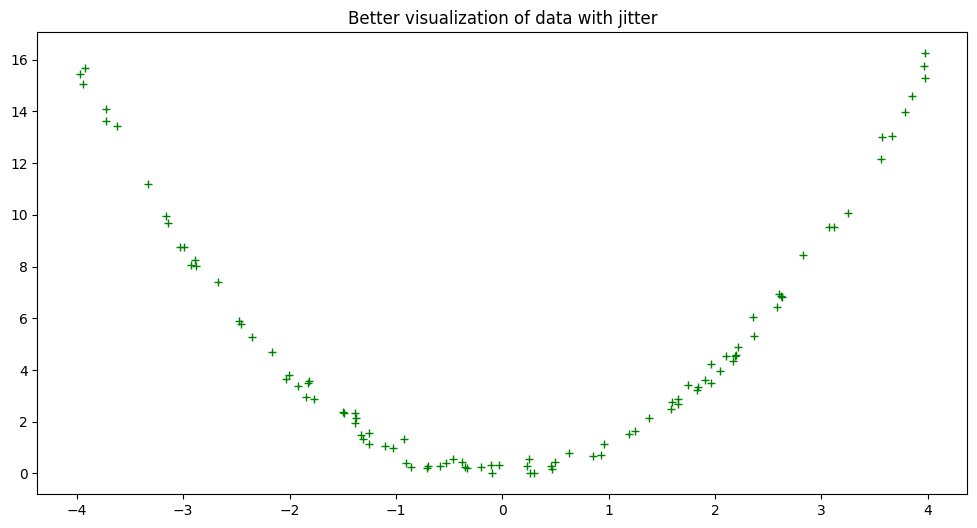

In [7]:
# To visulaize the jitter noise added in the data
# We try to simulate another set of x and y values

hundred_xt = np.random.uniform(-4, 4, 100)
xt = []
yt = []

for x in hundred_xt:
    y  = eval_2nd_degree_jitter(coeffs, x, 0.5)
    xt.append(x)
    yt.append(y)
  
plt.figure(figsize=(12, 6))
plt.plot(xt, yt, 'g+')
plt.title('Better visualization of data with jitter')
plt.show()

We will now build our predictive model, and optimize it with gradient descent and we will try to get as close to these values as possible.

To get a quantifiable measure of how incorrect it is, we calculate the Mean Squared Error loss for the model. This is the mean value of the sum of the squared differences between the actual and predicted outputs.

$$ E = \frac{1}{n} \sum_{i=0}^n (y_i - \bar{y_i})^2 $$

In [8]:
def loss_mse(ys, y_bar):
    """
    Calculates MSE loss.
    
    Args:
        ys: training data labels
        y_bar: prediction labels
    
    Returns: Calculated MSE loss.
    """

    return sum((ys - y_bar) * (ys - y_bar)) / len(ys)

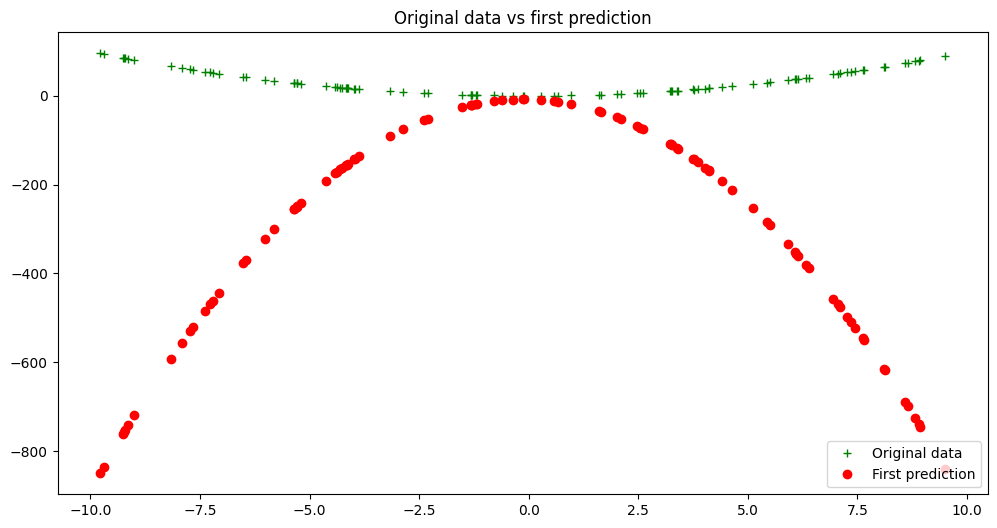

In [9]:
# First step, randomly predicting the coefficients  
rand_coeffs = (random.randrange(-10, 10), random.randrange(-10, 10), random.randrange(-10, 10))
y_bar = eval_2nd_degree(rand_coeffs, hundred_xs)
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+', label = 'Original data')
plt.plot(xs, y_bar, 'ro', label = 'First prediction')
plt.title('Original data vs first prediction')
plt.legend(loc="lower right")
plt.show()

In [10]:
initial_model_loss = loss_mse(ys, y_bar)
initial_model_loss

182358.6940136815

We can see that the loss is quite a large number. Let’s now see if we can improve on this fairly high loss metric by optimizing the model with gradient descent.

We wish to improve our model. Therefore we want to alter its coefficients $a$, $b$ and $c$ to decrease the error. Therefore we require knowledge about how each coefficient affects the error. This is achieved by calculating the partial derivative of the loss function with respect to **each** of the individual coefficients.

In [11]:
def calc_gradient_2nd_poly(rand_coeffs, hundred_xs, ys): 
    """
    calculates the gradient for a second degree polynomial.
    
    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points
        
    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.
    
    """
    
    a_s = []
    b_s = []
    c_s = []
    
    y_bars = eval_2nd_degree(rand_coeffs, hundred_xs)
    
    for x, y, y_bar in list(zip(hundred_xs, ys, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)
    
    # num = [i for i in y_bars]
    n = len(y_bars)
    
    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)

    return (gradient_a, gradient_b, gradient_c)   # return calculated gradients as a a tuple of its 3 parts

In [12]:
# Second step, finding the gradient of the problem
calc_grad = calc_gradient_2nd_poly(rand_coeffs, hundred_xs, ys)

lr = 0.0001 # learning rate

# Continuing the second step
# Changing the coeffients in the negative direction of the gradient
a_new = rand_coeffs[0] - lr * calc_grad[0]
b_new = rand_coeffs[1] - lr * calc_grad[1]
c_new = rand_coeffs[2] - lr * calc_grad[2]

new_model_coeffs = (a_new, b_new, c_new) # New coeffients
print(f"New model coeffs: {new_model_coeffs}")

# update with these new coeffs:
new_y_bar = eval_2nd_degree(new_model_coeffs, hundred_xs)
updated_model_loss = loss_mse(ys, new_y_bar)

print(f"Now have smaller model loss: {updated_model_loss} vs {initial_model_loss}")

New model coeffs: (-5.404617883175881, -2.002259184078606, -7.934671626289468)
Now have smaller model loss: 75991.70649385438 vs 182358.6940136815


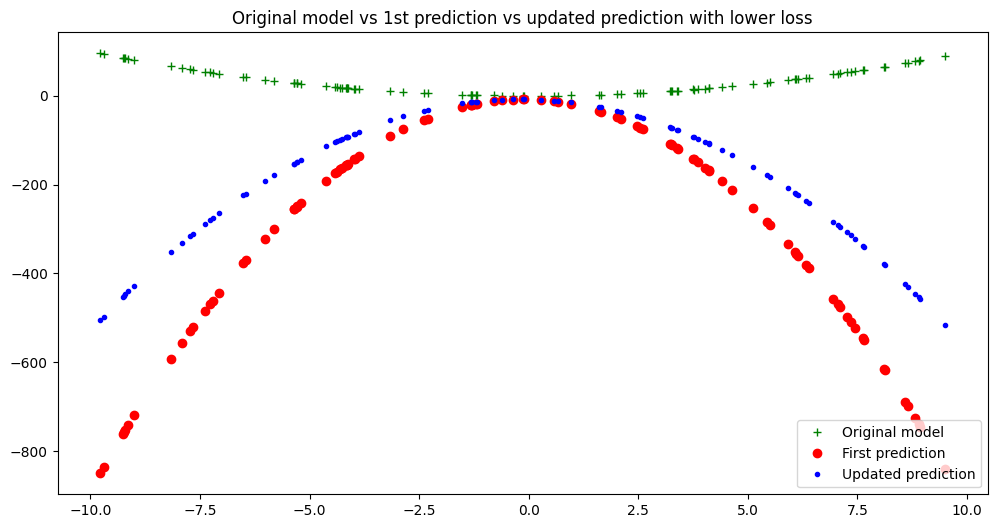

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+', label = 'Original model')
plt.plot(xs, y_bar, 'ro', label = 'First prediction')
plt.plot(xs, new_y_bar, 'b.', label = 'Updated prediction')
plt.title('Original model vs 1st prediction vs updated prediction with lower loss')
plt.legend(loc="lower right")
plt.show()

We’re almost ready. The last step will be to perform gradient descent iteratively over a number of epochs (cycles or iterations.) With every epoch we hope to see an improvement in the form of lowered loss, and better model-fitting to the original data.

In [14]:
def calc_gradient_2nd_poly_for_GD(coeffs, inputs_x, outputs_y, lr): 
    """
    calculates the gradient for a second degree polynomial.
    
    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points
        lr: learning rate
        
    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.
    
    """
    a_s = []
    b_s = []
    c_s = []
        
    y_bars = eval_2nd_degree(coeffs, inputs_x)

    for x,y,y_bar in list(zip(inputs_x, outputs_y, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2        
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)
    
    num = [i for i in y_bars]
    n = len(num)
    
    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)


    a_new = coeffs[0] - lr * gradient_a
    b_new = coeffs[1] - lr * gradient_b
    c_new = coeffs[2] - lr * gradient_c
    
    new_model_coeffs = (a_new, b_new, c_new)
    
    # update with these new coeffs:
    new_y_bar = eval_2nd_degree(new_model_coeffs, inputs_x)
    
    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar

In [15]:
def gradient_descent(epochs, lr):
    """
    Perform gradient descent for a second degree polynomial.
    
    Args:
        epochs: number of iterations to perform of finding new coefficients and updatingt loss. 
        lr: specified learning rate
        
    Returns: Tuple containing (updated_model_loss, new_model_coeffs, new_y_bar predictions, saved loss updates)
    
    """
    losses = []
    rand_coeffs_to_test = rand_coeffs
    
    # Third step, Here we are fixing the number of times, we are running the problem
    for i in range(epochs):
        loss = calc_gradient_2nd_poly_for_GD(rand_coeffs_to_test, hundred_xs, ys, lr)
        rand_coeffs_to_test = loss[1]
        losses.append(loss[0])
    print(losses)
    
    return loss[0], loss[1], loss[2], losses  # (updated_model_loss, new_model_coeffs, new_y_bar, saved loss updates)

[918.5343134202082, 156.58746979326918, 148.598826789757, 143.93709635545744, 139.46386152899936, 135.1594229588695, 131.01734218114873, 127.03147654011057, 123.19591600075087, 119.50497413082732, 115.95317964010286, 112.5352682405962, 109.24617481479898, 106.08102588020121, 103.03513233891842, 100.10398250162915, 97.28323537544802, 94.56871420574754, 91.95640026231969, 89.44242686063458, 87.02307360929962, 84.69476087516297, 82.4540444578249, 80.29761046563618, 78.22227038555856, 76.22495633955424, 74.30271652044617, 72.45271080045933, 70.67220650591001, 68.95857435175634, 67.30928452996254, 65.72190294585673, 64.19408759688429, 62.72358508836727, 61.30822728108881, 59.945928065713076, 58.634680259242934, 57.3725526188981, 56.15768696897079, 54.98829543638486, 53.86265779084602, 52.77911888562471, 51.73608619516611, 50.732027445861995, 49.765468336461545, 48.83499034472821, 47.93922861708029, 47.076869938075504, 46.246650776718816, 45.44735540668631, 44.67781409766995, 43.936901375150

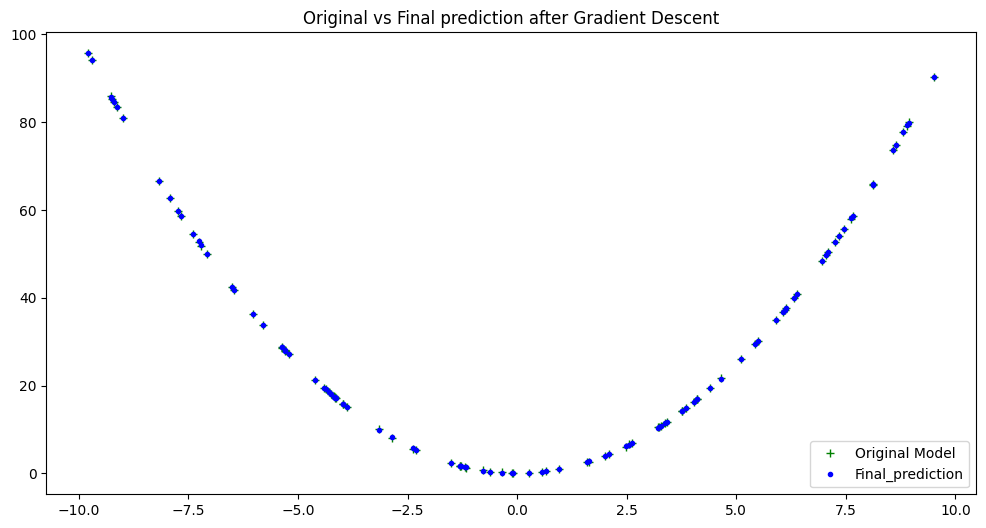

In [16]:
GD = gradient_descent(30000, 0.0003)

plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'Original Model')
plt.plot(xs, GD[2], 'b.', label = 'Final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

This trained model is showing vast improvements after it’s full training cycle. We can examine further by inspecting its final predicted coefficients $a$, $b$ and $c$.

In [17]:
print(f"Final Coefficients predicted: {GD[1]}")
print(f"Original Coefficients: {coeffs}")
print()
print(f"Initial Loss Calculated: {initial_model_loss}")
print(f"Loss calculated after last epoch: {GD[3][-1]}")

Final Coefficients predicted: (0.9998226783585835, 0.001921336209886381, 0.006855149615563168)
Original Coefficients: [1, 0, 0]

Initial Loss Calculated: 182358.6940136815
Loss calculated after last epoch: 0.0032831485523856984


Not too far off! A big improvement over the initial random model. Looking at the plot of the loss reduction over training offers further insights.


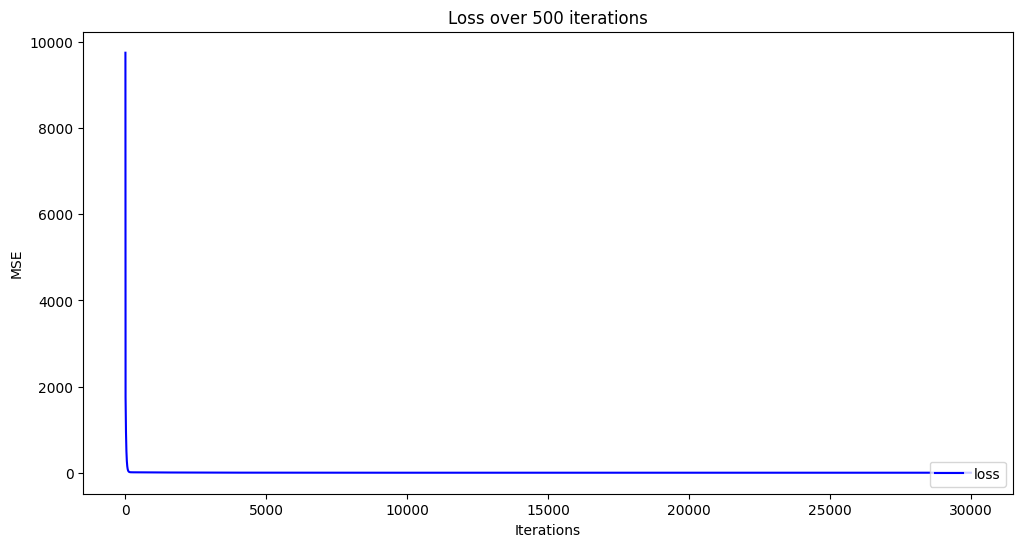

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(GD[3], 'b-', label = 'loss')
plt.title('Loss over 500 iterations')
plt.legend(loc="lower right")
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.show()

We observe that the model loss reached close to zero, to give us our more accurate coefficients. We can also see there was no major improvement in loss within about 100 epochs. An alternative strategy would be to add some kind of condition to the training step that stops training when a certain minimum loss threshold has been reached (another form of convergance criteria, which can be used for third step). This would prevent excessive training and potential over-fitting for the model.

NOTES:
- Please try to think on the mentioned questions first, apply on your own if possible rather than directly accessing the links. 
- But make sure, you do go through the given links at once. You can leave the discussion about the topics which are not known to you, if found difficult to understand.
<br><br>
# Things to try
1. Change the values of parameters in the functions and observe the changes in  the result.
1. Change the coefficients array and try a different polynomial instead of our $x^2$.
2. Increase/decrease the learning rate to see how many iterations will be take to coverge. Does it even converge on a huge learning rate?
  - https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/#:~:text=When%20the%20learning%20rate%20is,with%20a%20high%20training%20error.
3. Take a degree 5 polynomial with 5 roots and try different initializations, instead of random ones. Does it converge on different values for different initializations? Why does initialization not matter in our case of $x^2$?
  - This will help you understand the concepts of convex and non-convex optimization problems and will introduce you to the concept of local minima.
  - https://towardsdatascience.com/understand-convexity-in-optimization-db87653bf920
  - https://stats.stackexchange.com/questions/172900/can-gradient-descent-be-applied-to-non-convex-functions
4. Can you modify the algorithm to find a maxima of a function, instead of a minima?
  - https://towardsdatascience.com/minimizing-the-cost-function-gradient-descent-a5dd6b5350e1
5. Try to compare gradient descent algorithm with your understanding on perceptron learning algorithm?
  - https://stats.stackexchange.com/questions/137834/clarification-about-perceptron-rule-vs-gradient-descent-vs-stochastic-gradient
6. Now, since we know about both SVMs and Gradient Descent. Can Gradient Descent be used in for SVM Formulation?
  - https://towardsdatascience.com/solving-svm-stochastic-gradient-descent-and-hinge-loss-8e8b4dd91f5b



## 1. 

In [18]:
coeffs = [2, -1, 3]

[918.5343134202082, 156.58746979326918, 148.598826789757, 143.93709635545744, 139.46386152899936, 135.1594229588695, 131.01734218114873, 127.03147654011057, 123.19591600075087, 119.50497413082732, 115.95317964010286, 112.5352682405962, 109.24617481479898, 106.08102588020121, 103.03513233891842, 100.10398250162915, 97.28323537544802, 94.56871420574754, 91.95640026231969, 89.44242686063458, 87.02307360929962, 84.69476087516297, 82.4540444578249, 80.29761046563618, 78.22227038555856, 76.22495633955424, 74.30271652044617, 72.45271080045933, 70.67220650591001, 68.95857435175634, 67.30928452996254, 65.72190294585673, 64.19408759688429, 62.72358508836727, 61.30822728108881, 59.945928065713076, 58.634680259242934, 57.3725526188981, 56.15768696897079, 54.98829543638486, 53.86265779084602, 52.77911888562471, 51.73608619516611, 50.732027445861995, 49.765468336461545, 48.83499034472821, 47.93922861708029, 47.076869938075504, 46.246650776718816, 45.44735540668631, 44.67781409766995, 43.936901375150

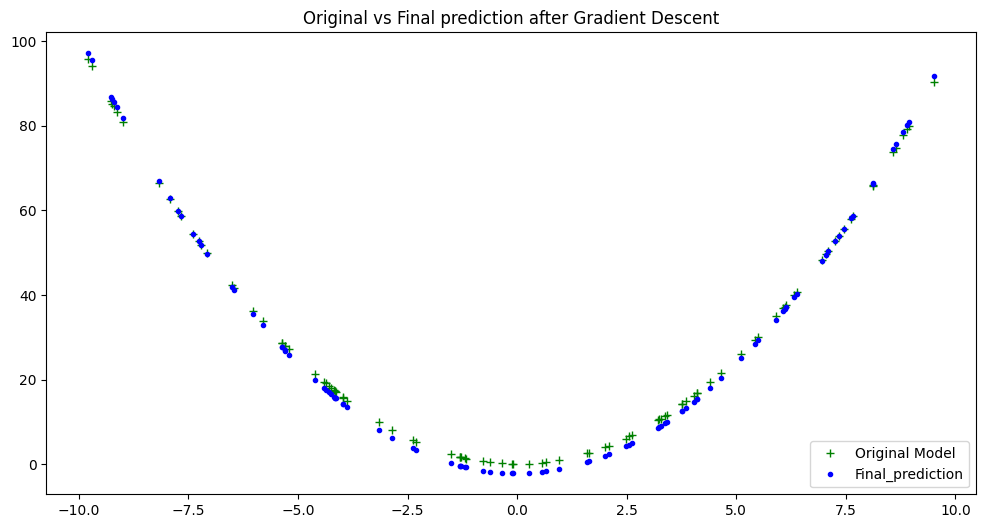

In [19]:
GD = gradient_descent(5000, 0.0003)

plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'Original Model')
plt.plot(xs, GD[2], 'b.', label = 'Final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

[123439.3334679671, 83573.11933208727, 56598.62053268306, 38346.898086528156, 25997.170253015986, 17640.843580704633, 11986.528196944533, 8160.445661089045, 5571.381202155288, 3819.3078886314597, 2633.56004061775, 1831.0002094505744, 1287.7141773076207, 919.8592669840197, 670.7059517381228, 501.86996726547426, 387.379795427594, 309.6626132963844, 256.8283115472891, 220.8318107400732, 196.22965030170224, 179.33867348307697, 167.66677793753578, 159.52775096410855, 153.78065986206212, 149.65351859260002, 146.6239773589627, 144.33859495471825, 142.55821693131512, 141.12101744896003, 139.91749270448364, 138.87354101870324, 137.93901450815076, 137.07997293265262, 136.27344250401404, 135.50386959802708, 134.76072126962103, 134.0368617163737, 133.32745376313122, 132.62921558568576, 131.93991779581637, 131.2580431593061, 130.58255635445832, 129.91274818606925, 129.2481301773469, 128.58836324849165, 127.93320945894713, 127.2824993549628, 126.63610987600318, 125.99394940547035, 125.35594765540621

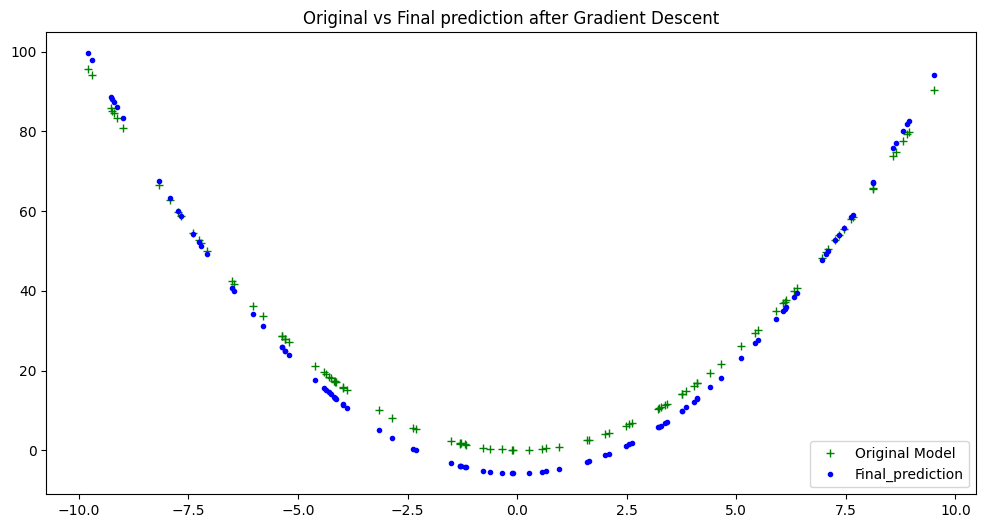

In [28]:
GD = gradient_descent(7000, 0.00005)

plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'Original Model')
plt.plot(xs, GD[2], 'b.', label = 'Final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

## 2.

In [29]:
def eval_3rd_degree(coeffs, x):
    """
    Function to return the output of evaluating a third degree polynomial,
    given a specific x value.
    
    Args:
        coeffs: List containing the coefficients a, b, c, and d for the polynomial.
        x: The input x value to the polynomial.
    
    Returns:
        y: The corresponding output y value for the third degree polynomial.
    
    """
    a = coeffs[0] * (x ** 3)
    b = coeffs[1] * (x ** 2)
    c = coeffs[2] * x
    d = coeffs[3]
    y = a + b + c + d
    return y

hundred_xs = np.random.uniform(-10, 10, 100)
coeffs = [1, -2, 3, 0]  # Coefficients for the third degree polynomial

xs = []
ys = []
for x in hundred_xs:
    y = eval_3rd_degree(coeffs, x)
    xs.append(x)
    ys.append(y)

In [30]:
def calc_gradient_3rd_poly(coeffs, inputs_x, outputs_y):
    """
    Calculates the gradient for a third degree polynomial.
    
    Args:
        coeffs: Coefficients [a, b, c, d] for the polynomial.
        inputs_x: Input x data points.
        outputs_y: Actual y output points.
        
    Returns: Calculated gradients for the third degree polynomial as a tuple (gradient_a, gradient_b, gradient_c, gradient_d).
    """
    gradient_a = np.mean((inputs_x ** 3) * (outputs_y - eval_3rd_degree(coeffs, inputs_x)))
    gradient_b = np.mean((inputs_x ** 2) * (outputs_y - eval_3rd_degree(coeffs, inputs_x)))
    gradient_c = np.mean(inputs_x * (outputs_y - eval_3rd_degree(coeffs, inputs_x)))
    gradient_d = np.mean(outputs_y - eval_3rd_degree(coeffs, inputs_x))
    
    return gradient_a, gradient_b, gradient_c, gradient_d

In [48]:
def gradient_descent_3(epochs, lr):
    """
    Performs gradient descent for a third degree polynomial.
    
    Args:
        epochs: Number of iterations to perform gradient descent.
        lr: Learning rate.
        
    Returns: Tuple containing (updated_coeffs, loss_history).
    """
    coeffs = np.random.uniform(-1, 2, 4)  # Initialize random coefficients
    loss_history = []

    for _ in range(epochs):
        gradient = calc_gradient_3rd_poly(coeffs, np.array(hundred_xs), np.array(ys))
        coeffs -= lr * np.array(gradient)
        y_bar = eval_3rd_degree(coeffs, np.array(hundred_xs))
        loss = loss_mse(np.array(ys), y_bar)
        loss_history.append(loss)

    return coeffs, loss_history

# Generate random input data
np.random.seed(42)
hundred_xs = np.random.uniform(-10, 10, 100)

# True coefficients for the third degree polynomial: y = x^3 - 2x^2 + 3x + 4
true_coeffs = [0.5, -0.7, 0.9, 1.2]

# Generate output data using the true coefficients
ys = [eval_3rd_degree(true_coeffs, x) for x in hundred_xs]

# Perform gradient descent
coeffs, loss_history = gradient_descent_3(10000, 0.01)

<ipython-input-8-310298a9b2b6>:12: RuntimeWarning: overflow encountered in multiply
  return sum((ys - y_bar) * (ys - y_bar)) / len(ys)


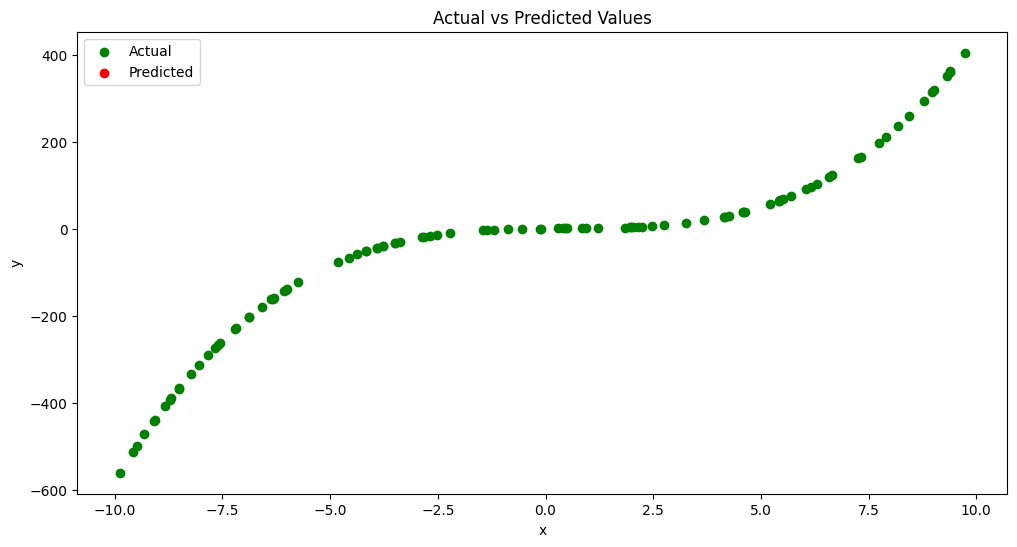

In [49]:
# Plot actual versus predicted values
plt.figure(figsize=(12, 6))
plt.scatter(hundred_xs, ys, color='g', label='Actual')
plt.scatter(hundred_xs, eval_3rd_degree(coeffs, np.array(hundred_xs)), color='r', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## 3.

no, it does not converge

<ipython-input-8-310298a9b2b6>:12: RuntimeWarning: overflow encountered in double_scalars
  return sum((ys - y_bar) * (ys - y_bar)) / len(ys)
<ipython-input-8-310298a9b2b6>:12: RuntimeWarning: overflow encountered in multiply
  return sum((ys - y_bar) * (ys - y_bar)) / len(ys)
<ipython-input-30-a6a69ee70672>:13: RuntimeWarning: overflow encountered in multiply
  gradient_b = np.mean((inputs_x ** 2) * (outputs_y - eval_3rd_degree(coeffs, inputs_x)))
<ipython-input-30-a6a69ee70672>:14: RuntimeWarning: overflow encountered in multiply
  gradient_c = np.mean(inputs_x * (outputs_y - eval_3rd_degree(coeffs, inputs_x)))


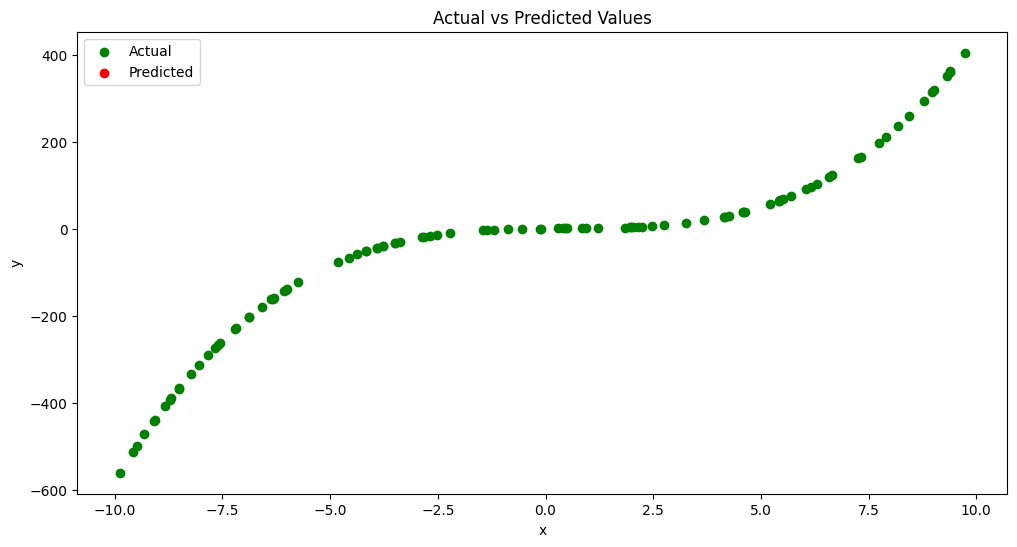

In [50]:
coeffs, loss_history = gradient_descent_3(10000, 0.1)
# Plot actual versus predicted values
plt.figure(figsize=(12, 6))
plt.scatter(hundred_xs, ys, color='g', label='Actual')
plt.scatter(hundred_xs, eval_3rd_degree(coeffs, np.array(hundred_xs)), color='r', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

<ipython-input-8-310298a9b2b6>:12: RuntimeWarning: overflow encountered in multiply
  return sum((ys - y_bar) * (ys - y_bar)) / len(ys)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


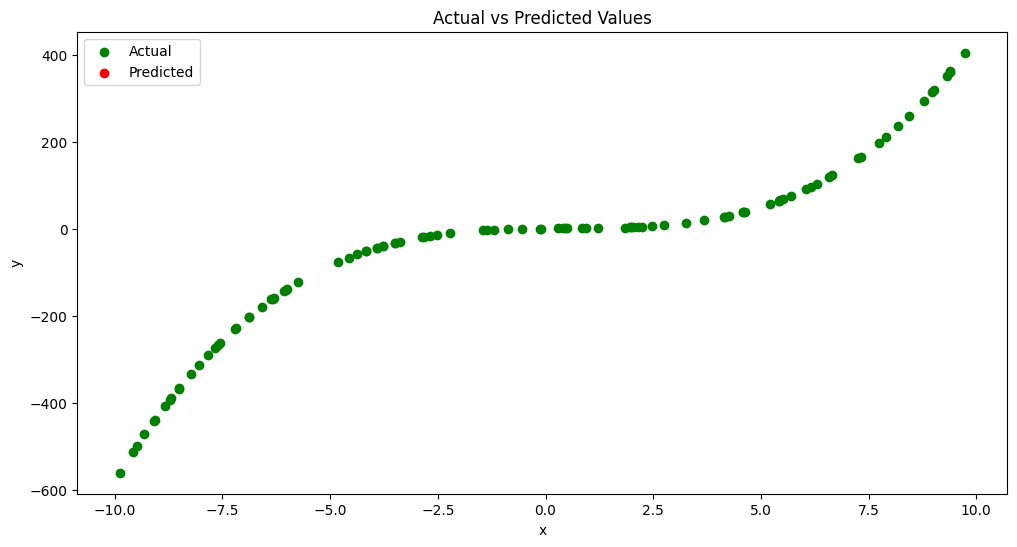

In [52]:
coeffs, loss_history = gradient_descent_3(10000, 0.5)
# Plot actual versus predicted values
plt.figure(figsize=(12, 6))
plt.scatter(hundred_xs, ys, color='g', label='Actual')
plt.scatter(hundred_xs, eval_3rd_degree(coeffs, np.array(hundred_xs)), color='r', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## 4.
When dealing with higher degree polynomials, such as a degree 5 polynomial, the optimization problem becomes non-convex. Non-convex optimization problems can have multiple local minima, which means that the convergence of the algorithm and the final solution can be highly dependent on the initialization of the coefficients.

In the case of a degree 2 polynomial (quadratic), the optimization problem is convex, which means it has a single global minimum. In this case, the initialization of the coefficients does not matter because the algorithm will always converge to the same optimal solution.



## 5. 

In [55]:
def calc_gradient_2nd_poly_for_GD(coeffs, inputs_x, outputs_y, lr): 
    """
    Calculates the gradient for a second degree polynomial.
    
    Args:
        coeffs: a, b, and c for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points
        lr: learning rate
        
    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a, b, c respectively.
    
    """
    a_s = []
    b_s = []
    c_s = []
        
    y_bars = eval_2nd_degree(coeffs, inputs_x)

    for x, y, y_bar in zip(inputs_x, outputs_y, y_bars):
        x_squared = x ** 2        
        partial_a = -x_squared * (y - y_bar)  # Negative sign here
        a_s.append(partial_a)
        partial_b = -x * (y - y_bar)  # Negative sign here
        b_s.append(partial_b)
        partial_c = -(y - y_bar)  # Negative sign here
        c_s.append(partial_c)
    
    num = [i for i in y_bars]
    n = len(num)
    
    gradient_a = (2 / n) * sum(a_s)  # Positive sign here
    gradient_b = (2 / n) * sum(b_s)  # Positive sign here
    gradient_c = (2 / n) * sum(c_s)  # Positive sign here


    a_new = coeffs[0] + lr * gradient_a  # Positive sign here
    b_new = coeffs[1] + lr * gradient_b  # Positive sign here
    c_new = coeffs[2] + lr * gradient_c  # Positive sign here
    
    new_model_coeffs = (a_new, b_new, c_new)
    
    # Update with these new coeffs
    new_y_bar = eval_2nd_degree(new_model_coeffs, inputs_x)
    
    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar

In [56]:
def gradient_descent(epochs, lr):
    """
    Perform gradient descent for a second degree polynomial.
    
    Args:
        epochs: number of iterations to perform of finding new coefficients and updating loss
        lr: learning rate
        
    Returns: Tuple containing (updated_model_loss, new_model_coeffs, new_y_bar predictions, saved loss updates)
    """
    losses = []
    rand_coeffs_to_test = rand_coeffs
    
    for i in range(epochs):
        loss = calc_gradient_2nd_poly_for_GD(rand_coeffs_to_test, hundred_xs, ys, lr)
        rand_coeffs_to_test = loss[1]
        losses.append(loss[0])
    
    print(losses)
    return loss[0], loss[1], loss[2], losses  # (updated_model_loss, new_model_coeffs, new_y_bar, saved loss updates)

## 6. 

The gradient descent algorithm and the perceptron learning algorithm are both iterative optimization algorithms, but they have some key differences:
Objective: The gradient descent algorithm aims to minimize a differentiable cost function by updating the parameters in the direction of steepest descent. On the other hand, the perceptron learning algorithm is specifically designed for binary classification tasks and updates the weight vector to correctly classify the training samples.

Learning Rule: In gradient descent, the update rule is based on the negative gradient of the cost function, multiplied by a learning rate. The perceptron learning algorithm updates the weight vector based on the misclassified samples, with the update proportional to the input vector and the class label.

Convergence: Gradient descent seeks to converge to an optimal solution by iteratively updating the parameters until a termination condition is met. The perceptron learning algorithm converges to a solution when the training samples are linearly separable, or it reaches a maximum number of iterations.

Loss Function: Gradient descent typically uses differentiable loss functions such as mean squared error or cross-entropy, while the perceptron learning algorithm uses the hinge loss function.

## 7.
Gradient descent can be used in SVM (Support Vector Machine) formulation. In fact, gradient descent is commonly used to solve the optimization problem in the training of SVM models.
In SVM, the objective is to find the optimal hyperplane that maximizes the margin between the classes while minimizing the classification error. This optimization problem can be formulated as a convex quadratic programming problem, and various optimization algorithms, including gradient descent, can be used to solve it.

Gradient descent can be used to minimize the SVM objective function, which involves both the regularization term and the hinge loss term. By iteratively updating the model parameters (weights and biases) in the direction of steepest descent of the objective function, gradient descent can find the optimal solution that maximizes the margin and achieves good classification performance.